In [ ]:
# Unfreeze last 100 layers for fine-tuning, which was 20 layers in the previous trial.

In [1]:
# EfficientNet-B7 achieves new state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy year 2019 while being 8.4x
# smaller than the best existing CNN, e.g. EfficientNet-B1 is 7.6x smaller and 5.7x faster than ResNet-152.
# We are using EfficientNet-B5 to make the computing process faster and it's more efficient in our case.
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime():
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    print("CDT(Current Date and Time):", datetime_string)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

print_current_datetime()

# Dataset directory hierarchy structure
'''
dataset/
    train/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
            ...
        class3/
            img1.jpg
            img2.jpg
            ...
    validation/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
            ...
        class3/
            img1.jpg
            img2.jpg
            ...
'''

# Configuration : EfficientNetB5
path_train = 'dataset/train'
path_validation = 'dataset/validation'
img_height = 456
img_width = 456

# Create an instance of the ImageDataGenerator class
train_datagen_ins = ImageDataGenerator(rescale=1/255)
val_datagen_ins = ImageDataGenerator(rescale=1/255)

# The ImageDataGenerator class will automatically load the images
# and generate one-hot encoded labels based on the directories.

# Load the training data and labels from a directory
train_generator = train_datagen_ins.flow_from_directory(
    path_train,
    target_size=(img_height,img_width),
    batch_size=2, # 64 preferred (depending on the dataset size)
    class_mode='categorical',
    #class_mode="binary" # The labels are binary (either 0 or 1)
)

val_generator = val_datagen_ins.flow_from_directory(
    path_validation,
    target_size=(img_height,img_width),
    batch_size=2, # 64 preferred (depending on the dataset size)
    class_mode='categorical',
    #class_mode="binary" # The labels are binary (either 0 or 1)
)

# Get a batch of data from the train_generator
X_batch, y_batch = next(train_generator)

# Check the shape of the data and labels
print('Data shape:', X_batch.shape)
print('Labels shape:', y_batch.shape)

# Check the range of pixel values
print('Min pixel value:', X_batch.min())
print('Max pixel value:', X_batch.max())

# Check the class indices and class names
print('Class indices:', train_generator.class_indices)
print('Class names:', list(train_generator.class_indices.keys()))

print_current_datetime()

2023-03-29 10:30:52.817788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-29 10:30:52.817844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CDT(Current Date and Time): 2023-03-29 10:30:55.478954
Found 24 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Data shape: (2, 456, 456, 3)
Labels shape: (2, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Class indices: {'class1': 0, 'class2': 1, 'class3': 2}
Class names: ['class1', 'class2', 'class3']
CDT(Current Date and Time): 2023-03-29 10:30:55.505328


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

print_current_datetime()

# Load the pre-trained model
base_model = load_model('efficientnet-b5-pretrained-on-imagenet.h5')

# Add custom layers for classification
# for 3 different classes to classify
base_model_output = base_model.output
base_model_output = GlobalAveragePooling2D()(base_model_output)
base_model_output = Dense(512, activation='relu')(base_model_output)
base_model_output = Dropout(0.5)(base_model_output)
predictions = Dense(3, activation='softmax')(base_model_output)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()

# Print trainable and non-trainable parameters
print("Trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.trainable_weights]))
print("Non-trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.non_trainable_weights]))

print_current_datetime()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# Compile the model and freeze the base model layers
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
for layer in base_model.layers:
    layer.trainable = False

# Print trainable and non-trainable parameters
print("Trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.trainable_weights]))
print("Non-trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.non_trainable_weights]))

# Train the model on new layers for few epochs
model.fit(train_generator, epochs=10, verbose=1)

print_current_datetime()

# Compile the model and unfreeze some of the base model layers and continue training
#for layer in base_model.layers[-20:]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Print trainable and non-trainable parameters
print("Trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.trainable_weights]))
print("Non-trainable parameters:")
print(tf.reduce_sum([tf.reduce_prod(w.shape) for w in model.non_trainable_weights]))

# 모델 학습 시 성능이 개선되지 않는 횟수가 5회를 초과하면 학습을 멈춤
earlystop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator,
          validation_data=val_generator,
          callbacks=[earlystop_callback],
          epochs = 100,
          verbose=1)

model.save('efficientnet_finetuned_earlystop_epochs.h5')

print_current_datetime()

CDT(Current Date and Time): 2023-03-29 10:30:59.450895


2023-03-29 10:30:59.828417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-29 10:30:59.828448: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-29 10:30:59.828466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-03-29 10:30:59.828653: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trainable parameters:
tf.Tensor(29391411, shape=(), dtype=int32)
Non-trainable parameters:
tf.Tensor(172743, shape=(), dtype=int32)
CDT(Current Date and Time): 2023-03-29 10:31:07.278361
Trainable parameters:
tf.Tensor(1050627, shape=(), dtype=int32)
Non-trainable parameters:
tf.Tensor(28513527, shape=(), dtype=int32)
Epoch 1/10
12/12 [==============================] - 62s 3s/step - loss: 1.1174 - accuracy: 0.2917
Epoch 2/10
12/12 [==============================] - 40s 3s/step - loss: 1.0743 - accuracy: 0.4583
Epoch 3/10
12/12 [==============================] - 35s 3s/step - loss: 1.0496 - accuracy: 0.5417
Epoch 4/10
12/12 [==============================] - 38s 3s/step - loss: 1.0248 - accuracy: 0.5833
Epoch 5/10
12/12 [==============================] - 39s 3s/step - loss: 0.9436 - accuracy: 0.6250
Epoch 6/10
12/12 [==============================] - 36s 3s/step - loss: 0.9859 - accuracy: 0.5000
Epoch 7/10
12/12 [==============================] - 39s 3s/step - loss: 0.8658 - accuracy: 0

/home/gbike/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


CDT(Current Date and Time): 2023-03-29 10:41:58.162852


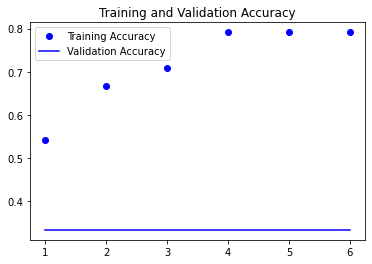

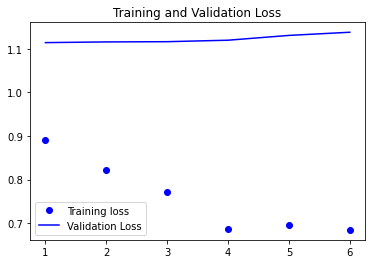

In [4]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [5]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np

model_loaded = load_model('efficientnet_finetuned_earlystop_epochs.h5')

img_path = 'image1.jpg'
img_resized = tf.keras.preprocessing.image.load_img(img_path, target_size=(456, 456)) # EfficientNetB5
img_vectorized = tf.keras.preprocessing.image.img_to_array(img_resized)
img_vectorized = tf.keras.applications.efficientnet.preprocess_input(img_vectorized)
img_vectorized = np.expand_dims(img_vectorized, axis=0)

predicted_result = model_loaded.predict(img_vectorized)
print(predicted_result)

# Get the predicted label name: class1(0), class2(1), class3(2)
label_map = {0: "Cat", 1: "Dog", 2: "Human"}
predicted_label_id = np.argmax(predicted_result)
predicted_label_name = label_map[predicted_label_id]

print(predicted_label_name)

[[0.35329908 0.3011299  0.345571  ]]
Cat


In [10]:
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the model
model_loaded = load_model('efficientnet_finetuned_earlystop_2023-03-29.h5')

# Load the data
'''
directory: the directory where the images are stored.
labels: specifies how to infer the labels of the images.
The value 'inferred' means the labels will be automatically
inferred from the subdirectories of the main directory.
'''
test_dataset = image_dataset_from_directory(
    directory='dataset/validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(456, 456))

# Evaluate the model
model_loaded.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_loaded.evaluate(test_dataset, verbose=1)

'''
Output:
Found 6 files belonging to 3 classes.
1/1 [==============================] - 6s 6s/step - loss: 1.0312 - accuracy: 0.5000
[1.031218409538269, 0.5]

Comments:
Evaluation on 6 images belonging to 3 classes
The loss value and accuracy of the model on this batch
were calculated as 1.0312 and 0.5, respectively.
'''

Found 6 files belonging to 3 classes.
1/1 [==============================] - 5s 5s/step - loss: 1.0312 - accuracy: 0.5000


'\nOutput:\nFound 6 files belonging to 3 classes.\n1/1 [==============================] - 6s 6s/step - loss: 1.0312 - accuracy: 0.5000\n[1.031218409538269, 0.5]\n\nComments:\nEvaluation on 6 images belonging to 3 classes\nThe loss value and accuracy of the model on this batch\nwere calculated as 1.0312 and 0.5, respectively.\n'

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the model
model_loaded = load_model('efficientnet_finetuned_earlystop_2023-03-29.h5')

# Create an ImageDataGenerator for test set
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(456, 456),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Evaluate the model on the test set
loss, acc = model_loaded.evaluate(test_generator, verbose=1)

# Predict the classes of test images
y_pred = model_loaded.predict(test_generator)

# Get the true classes of test images
y_true = test_generator.classes

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, tf.argmax(y_pred, axis=1))

# Print metrics
print('Test loss:', loss)
print('Test accuracy:', acc)
print('Confusion matrix:')
print(cm)

Found 6 images belonging to 3 classes.
1/1 [==============================] - 4s 4s/step - loss: 1.0053 - accuracy: 0.8333
Test loss: 1.005331039428711
Test accuracy: 0.8333333134651184
Confusion matrix:
tf.Tensor(
[[2 0 0]
 [0 2 0]
 [0 1 1]], shape=(3, 3), dtype=int32)


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test dataset
test_data_dir = 'dataset/validation'
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=(456, 456),
    batch_size=1, # Precision, Recall, and F1-score may vary by this value.
    class_mode='categorical',
    shuffle=False
)

# Load the trained model
model_loaded = tf.keras.models.load_model('efficientnet_finetuned_earlystop_2023-03-29.h5')

# Evaluate the model on the test dataset
eval_results = model_loaded.evaluate(test_generator)

# Print the evaluation metrics
print("Test loss:", eval_results[0])
print("Test accuracy:", eval_results[1])

# Predict the class labels for the test dataset
y_pred = model_loaded.predict(test_generator)
y_pred = tf.argmax(y_pred, axis=1)

# Get the true class labels for the test dataset
y_true = test_generator.classes

print(y_pred)
print(y_true)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(confusion_mtx)

'''
In Keras, precision and recall are calculated as streaming metrics.
This means that they accumulate values across multiple batches and take
the average of these values to calculate the final precision and recall.
This is useful when you are working with large datasets
that cannot be loaded into memory all at once.
'''

# Compute and print precision and recall
precision = tf.keras.metrics.Precision()
precision.update_state(y_true, y_pred)
print("[keras] Precision:", precision.result().numpy())

recall = tf.keras.metrics.Recall()
recall.update_state(y_true, y_pred)
print("[keras] Recall:", recall.result().numpy())

f1_score = 2*((precision.result()*recall.result())/(precision.result()+recall.result()))
print("[keras] F1 score:", f1_score.numpy())

from sklearn.metrics import precision_score, recall_score, f1_score

'''
On the other hand, in scikit-learn, precision and recall are calculated on the entire dataset at once.
This means that there is a need having enough memory to load the entire dataset into memory.

The average parameter is set to 'weighted' in order to compute the weighted average
precision, recall, and F1 score. The weighted average takes into account the number
of samples in each class and can provide a better metric for imbalanced datasets.
The number of samples that the weighted average takes into account depends on
the distribution of samples across the classes. Classes with more samples
will have a higher weight and contribute more to the overall score.
'''

s_precision = precision_score(y_true, y_pred, average='weighted')
s_recall = recall_score(y_true, y_pred, average='weighted')
s_f1 = f1_score(y_true, y_pred, average='weighted')

print("[sklearn] Precision:", s_precision)
print("[sklearn] Recall:", s_recall)
print("[sklearn] F1 score:", s_f1)

Found 6 images belonging to 3 classes.
6/6 [==============================] - 4s 196ms/step - loss: 1.1144 - accuracy: 0.3333
Test loss: 1.114362359046936
Test accuracy: 0.3333333432674408
tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
[0 0 1 1 2 2]
Confusion matrix:
tf.Tensor(
[[2 0 0]
 [2 0 0]
 [2 0 0]], shape=(3, 3), dtype=int32)
[keras] Precision: 0.0
[keras] Recall: 0.0
[keras] F1 score: nan
[sklearn] Precision: 0.1111111111111111
[sklearn] Recall: 0.3333333333333333
[sklearn] F1 score: 0.16666666666666666


/home/gbike/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
